In [1]:
import ResonatorOptimizer as ro
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn-deep')

In [2]:
# Global Parameters
__er = 11.9
__fo = 7.3e09
__h = 500e-06
__t = 50e-09
__pen_depth = 39e-09
__total_width = 43.6e-06
__length = 8102.64e-06
freq = np.linspace(2,12,30000)*1e09

__keyind = lambda X,X_array: min(enumerate(X_array), key=lambda x: abs(x[1]-X))

In [3]:
class Bragg:
    def __init__(self,fo,er,h,t,pen_depth):
        self.__fo = fo
        self.__er = er
        self.__h = h
        self.__t = t
        self.__pen_depth = pen_depth
        return
    
    def get_abcd(self,cpw,freq,length):
        gamma = cpw.gamma(freq,tan_d=0)
        Z0 = cpw.impedance_kinetic()

        sp = ro.Sparams(freq=freq,gamma=gamma,length=length,Z0=Z0)
        abcd = sp.transmission()
        return abcd

    def cpw_section(self,width, gap, length):
        cpw = ro.cpwCalcs(width,gap,length,self.__fo, self.__er, h=self.__h, t=self.__t, pen_depth=self.__pen_depth)
        return cpw

    def bragg_resonator(self,freq,lowZ, highZ, cavity):  
        cav_abcd = self.get_abcd(cavity,freq,cavity.cpw_params().length.values[0])
        lowZ_abcd = self.get_abcd(lowZ,freq,lowZ.cpw_params().length.values[0])
        highZ_abcd = self.get_abcd(highZ,freq,highZ.cpw_params().length.values[0])
        
        mirror_lhs = [np.matmul(lowZ_abcd[i], highZ_abcd[i]) for i in range(len(freq))]
        mirror_rhs = [np.matmul(highZ_abcd[i], lowZ_abcd[i]) for i in range(len(freq))]
        bragg = [np.matmul(mirror_lhs[i]**5, np.matmul(cav_abcd[i], mirror_rhs[i]**5)) for i in range(len(freq))]

        sp = ro.Sparams(freq=freq)
        bragg_s21 = sp.s21_from_abcd(bragg)
        return bragg_s21

In [3]:
br = ro.Bragg(__fo,__er,__h,__t,__pen_depth)

cav_width, cav_gap, cav_length = [21.6e-06, 11.1e-06, 8102.64e-06]
cavity = br.cpw_section(cav_width, cav_gap, cav_length)

lowZ_width, lowZ_gap, lowZ_length = [36.6e-06, 3.6e-06, 4091.32e-06]
lowZ = br.cpw_section(lowZ_width, lowZ_gap, lowZ_length)

highZ_width, highZ_gap, highZ_length = [7.8e-06, 18e-06, 3566.32e-06]
highZ = br.cpw_section(highZ_width, highZ_gap, highZ_length)

bragg = br.bragg_resonator(freq,lowZ, highZ, cavity)

/Users/garethjones/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


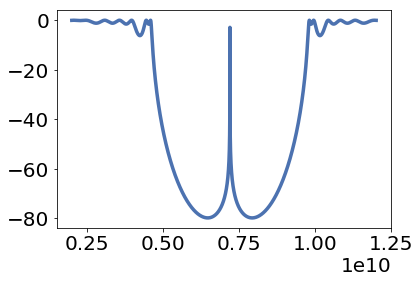

In [4]:
plt.plot(freq,bragg)
plt.show()